# Applying Classification

In this chapter we'll look at a few examples of applying classification.  We'll start by looking at A/B testing like we did for applying hypothesis testing.  Then we'll move onto an example with customer churn where the data is unbalanced.  We'll end the chapter with an example of credit card fraud.  

## A/B Testing

Recall from the Applying Statistical Tests chapter we want to send an email about a towel sale.  We will have both a control and test group - one in which something about the email changed (test) and one in which the email stays the same as in the past (control).  We will use these two samples to set up an experiment.  Did changing the email effect things?

Last time we answered this question with hypothesis testing.  Now we will answer it with a classifier!

### Recall Set Up

In order to test this question, we can set up an experiment.  Here we will set up a randomized test group and a randomized control group.  

The test group will be sent an email, with slightly different copy, or possibly with a picture.  Some specific change will be made, in any event.

The control group will get the same email as last time.  This way, we can directly compare, as much as possible between the old email and the new one.  There are many things you typically need to control for, or account for in experimental design.  Some things to account for in this scenario are:

1) Age

2) Gender

3) Race

4) Location

5) Approximate Disposable Income


## Simulating Some Data

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [138]:
import random
import pandas as pd
import numpy as np

def generate_categorical_data(df, column, choices, size):
    """
    Generates categorical data given choices.
    
    Parameters:
    * df - pd.DataFrame: the data to add a column to
    * column - str: the column to generate
    * choices - list: the list of possible choices
    
    Returns:
    A dataframe with the newly generated column.
    """
    df[column] = [random.choice(choices)
                  for _ in range(size)]
    df = pd.concat([df, pd.get_dummies(df[column])], axis=1)
    df = df.drop(column, axis=1)
    return df

def converted_score(x):
    if x["male"] == 1:
        gender = 0.7
    elif x["female"] == 1:
        gender = 1.4
    if x["white"] == 1:
        race = 0.5
    elif x["black"] == 1:
        race = 1.4
    elif x["asian"] == 1:
        race = 2.8
    elif x["hispanic"] == 1:
        race = 3.7
    disposable_income_alpha = gender * race
    age_alpha = gender + race
    return disposable_income_alpha * x["disposable_income"] + age_alpha * x["age"]

def decision_boundary(result):
    if result > 95000:
        return 1
    else:
        return 0

def generate_data(size, salary_mean, salary_variance):
    df = pd.DataFrame()

    gender_choices = ["male", "female"]
    race_choices = ["white", "black", "asian", "hispanic"]
    location_choices = ["high", "medium", "low"]

    df = generate_categorical_data(df, "gender", gender_choices, size)
    df = generate_categorical_data(df, "race", race_choices, size)
    df = generate_categorical_data(df, "location", location_choices, size)
    df["age"] = np.random.normal(50, 25, size=len(df))
    df["age"] = df["age"].astype(int)
    df["salary"] = np.random.normal(salary_mean, 
                                    salary_variance, 
                                    size=len(df))
    df["salary"] = df["salary"].apply(lambda x: round(x, 2))
    df.index = range(len(df))
    disposable_income = []
    for index, row in df.iterrows():
        if df.iloc[index]["high"] == 1:
            disposable_income.append(df.iloc[index]["salary"] - 55000)
        if df.iloc[index]["medium"] == 1:
            disposable_income.append(df.iloc[index]["salary"] - 35000)
        if df.iloc[index]["low"] == 1:
            disposable_income.append(df.iloc[index]["salary"] - 15000)

    df["disposable_income"] = np.array(disposable_income)
    df["converted"] = df.apply(converted_score, axis=1)
    df["converted"] = df["converted"].apply(decision_boundary)
    return df

size = 5000
test_salary_mean = 150000
test_salary_variance = 30000 
control_salary_mean = 55000
control_salary_variance = 2000

test_df = generate_data(size, test_salary_mean, test_salary_variance)
control_df = generate_data(size, control_salary_mean, test_salary_variance)
original_df = generate_data(size*2, control_salary_mean, test_salary_variance)
print(test_df["converted"].value_counts()/len(test_df))
print(control_df["converted"].value_counts()/len(control_df))
print(original_df["converted"].value_counts()/len(original_df))

1    0.7364
0    0.2636
Name: converted, dtype: float64
0    0.7814
1    0.2186
Name: converted, dtype: float64
0    0.7939
1    0.2061
Name: converted, dtype: float64


Now we will look at some strategies for telling if data is different based on the classifier.  

## Comparing Data Based On Classifiers

* training a surrogate model
* comparing predicted probability distribtions

It's important to note that the overall size of the datasets will matter for all of these analyses.  So please make sure to only apply these techniques when test and control have the same overall size.

### Training a surrogate model

For this setup we will make use of three labeled datasets - 

1. `original_df` this is data collected before the start of the experiment.  It's the current state prior to any intervention.  For our example it's the number of towels we sell now, from emailing folks, using the original language about a sale.  We are making a pretty big assumption here, that each sale is an "apples to apples" comparison.  That our set up and general assumptions are the same from previous sales to this one.

2. `test_df` this is data collected during the experiment, where something about the email telling folks about the sale has changed.  

3. `control_df` this is also data collected during the experiment, where the email is the same as the original email used.  By looking at a `control_df` and an `original_df` we can ensure that we are likely making an "apples to apples" comparison.

As you can see above, the conversion rates are about the same for `original_df` and `control_df`.  Because this is a worked example, we know that the parameters for folks going into the data were also the same.  The reason why the `original_df` more conversions is because we are using double the data for `original_df`.
 
Now that we understand our data, let's walk through what we are going to do:

1. split `original_df` into `X_train` and `X_val`
2. Use `X_train` to train a classifier
3. Predict and record the classifier's performance on `X_val`
4. Predict on `X_test` with the original classifier and train a surrogate classifier on `X_test` and the predictions from `X_test` with the original classifier.
5. Use the surrogate model to predict on `X_control`.  
6. Look at the metrics for both classifiers.

The above steps outline the ability to discern between two states:

1. The state where `control_df` and `original_df` are the same but `test_df` is different
2. The state where `control_df`, `test_df` and `original_df` are the same.

We are able to discern which state we are in by observing:
* precision
* recall
* F1 score
* ROC AUC 

Between the predictions on the surrogate classifier, the one trained on the test data as well as the predicted labels from the original data.  And the predictions on the original classifier, trained on the original data and the original labels.  

The reason this works is because a model is simply a description of our data.  By assuming we are in state two, training on the predictions from our original classifier, if our predictions are off, then we have some confidence we are actually in state one.  If our predictions are close to what our original classifier found, then we are in fact in state two.  

In this way, we can see our predictions on our original data set as a reference point for what we should expect from new data, namely our test data.  If our `X_test` is indeed different then our predictions on `X_control` will differ from it's true labels more so than occurs with our original dataset, `original_df`.  Essentially, this is our way of accounting for the fact that all models are merely representations of data, and therefore subject to error.

With the motivation out of the way, let's look at our example:

prediction on the control group
              precision    recall  f1-score   support

           0       0.95      0.74      0.83      3983
           1       0.45      0.85      0.59      1017

    accuracy                           0.76      5000
   macro avg       0.70      0.80      0.71      5000
weighted avg       0.85      0.76      0.78      5000

ROC AUC 0.7951757111282438


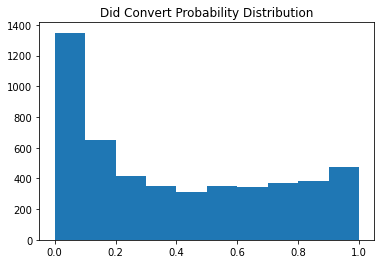

In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def get_xy(df):
    y = df["converted"]
    cols = df.columns.tolist()
    cols.remove("converted")
    X = df[cols]
    return X, y

X_original, y_original = get_xy(original_df)
X_control, y_control = get_xy(control_df)
X_test, y_test = get_xy(test_df)

X_train, X_val, y_train, y_val = train_test_split(
    X_original, y_original, test_size=0.5
)
clf = LogisticRegression(
    max_iter=1000, class_weight="balanced", 
    C=100, penalty="l2"
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print("prediction on the control group")
print(classification_report(y_val, y_pred))
print("ROC AUC", roc_auc_score(y_val, y_pred))
plt.hist(clf.predict_proba(X_val).T[1])
plt.title('Did Convert Probability Distribution')
plt.show()

prediction on the test group
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      3983
           1       0.48      0.83      0.61      1017

    accuracy                           0.78      5000
   macro avg       0.71      0.80      0.73      5000
weighted avg       0.85      0.78      0.80      5000

ROC AUC 0.8004173835161283


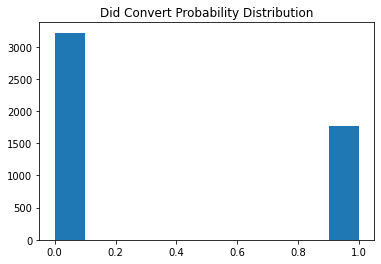

In [74]:
surrogate_clf = LogisticRegression(**clf.get_params())
y_test_pred = clf.predict(X_test)
surrogate_clf.fit(X_test, y_test_pred)
y_control_pred = surrogate_clf.predict(X_control)
print("prediction on the test group")
print(classification_report(y_control, y_control_pred))
print("ROC AUC", roc_auc_score(y_control, y_control_pred))
plt.hist(surrogate_clf.predict_proba(X_control).T[1])
plt.title('Did Convert Probability Distribution')
plt.show()

## Interpretation

As you can see above the precision, recall, F1 score and ROC AUC are very similar for both models.  So we can likely conclude that our intervention changed very little about buying habits.  Just for thoroughness, let's look at our three datasets:

In [75]:
test_df.describe()

,female,male,asian,black,hispanic,white,high,low,medium,age,salary,disposable_income,converted
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.505800,0.494200,0.243000,0.248400,0.251600,0.257000,0.321200,0.327800,0.351000,49.448800,149718.134086,114850.134086,0.732000
std,0.500016,0.500016,0.428938,0.432128,0.433976,0.437023,0.466984,0.469458,0.477331,25.015286,30040.547729,33987.683316,0.442962
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-37.000000,45295.990000,4408.980000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,129124.750000,91634.542500,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,149666.990000,114443.695000,1.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,66.250000,170611.505000,137981.645000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,133.000000,256091.170000,238710.250000,1.000000


In [76]:
control_df.describe()

,female,male,asian,black,hispanic,white,high,low,medium,age,salary,disposable_income,converted
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499200,0.500800,0.260000,0.246400,0.240000,0.253600,0.342200,0.330400,0.327400,49.568400,54580.240402,19344.240402,0.203400
std,0.500049,0.500049,0.438678,0.430957,0.427126,0.435115,0.474494,0.470404,0.469312,24.918032,30688.027926,34746.902744,0.402568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-42.000000,-67337.100000,-100401.680000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,33118.727500,-4888.745000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,54572.295000,18414.445000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,67.000000,75420.480000,42517.287500,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,132.000000,179189.460000,131496.400000,1.000000


In [77]:
original_df.describe()

,female,male,asian,black,hispanic,white,high,low,medium,age,salary,disposable_income,converted
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,0.490500,0.509500,0.25370,0.244700,0.254800,0.246800,0.324400,0.332600,0.343000,49.36310,54933.781937,20097.781937,0.217800
std,0.499935,0.499935,0.43515,0.429931,0.435771,0.431171,0.468174,0.471168,0.474735,25.26508,30043.041810,34068.392911,0.412771
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-48.00000,-61391.770000,-114280.390000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.00000,34677.185000,-3063.357500,0.000000
50%,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.00000,54925.500000,20312.720000,0.000000
75%,1.000000,1.000000,1.00000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,66.00000,75564.272500,43323.185000,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,148.00000,162595.460000,138077.200000,1.000000


We can see a huge difference in salary!  Let's look at how big the difference is on average:

In [78]:
test_df["salary"].mean() - control_df["salary"].mean()

95137.89368400001

Around 95K!  That's a huge difference in standard of living.  Let's go back to our model and look at our coefficients:

In [79]:
for index, coef in enumerate(surrogate_clf.coef_[0]):
    print(test_df.columns[index], coef)

female 0.0003208334043427795
male -0.022485068868729544
asian -0.03359746304814557
black 0.009960850420642514
hispanic 0.008589031729164314
white -0.007116654566048063
high 0.038800305545552936
low 1.5309446611197052e-05
medium -0.06097985045655087
age -6.850696693020392
salary -0.01256632290792235
disposable_income 0.03575295179205097


In [80]:
for index, coef in enumerate(clf.coef_[0]):
    print(control_df.columns[index], coef)

female 0.00026483850132171996
male -0.0005516986458904975
asian 0.00014863018238960596
black -0.00035226344947406426
hispanic 0.00042828858689245784
white -0.0005115154643767762
high 0.00012922721936690074
low -0.0003727723526543467
medium -4.331501128133094e-05
age -0.016559306701229876
salary -2.9369888929442916e-05
disposable_income 8.424959333483499e-05


The big thing to pay attention to here is effect size - how the size of the variable and it's weight changes the decision or result of the model.

Let's look at the surrogate model first:

The effect size of salary may _seem_ small based on these coefficients, but I assure you it's not.  Recall, that for logistic regression the equation is:

$$ \theta_{i}x_{i} $$

That means we need to consider the _multiplication_ of these two variables.  Let's just look at the average salary for the two groups to get a sense of effect size:

$$ \theta * mean(salary) = 1881.4064180962919 $$

That is, `0.01256632290792235 * 149718.134086  = 1881.4064180962919`.

Given that effect size is exponentiated by the base, in this case $e$, the natural number.  We have, an increase in salary by 1 dollar leading to an increase in P(Y=1) of:

$$ e^{1881.4064180962919} = 1.2145785208091 × 10^817 $$

Which is _a lot_.  Especially given the effect size of the other coefficients.

Now let's look at the original model:

$$ \theta * mean(salary) = 1.6133990739639275 $$

That is, `2.9369888929442916e-05 * 54933.781937 = 1.6133990739639275`.

Given that effect size is exponentiated by the base, in this case $e$, the natural number.  We have, an increase in salary by 1 dollar leading to an increase in P(Y=1) of:

$$ e^{1.6133990739639275} = 5.019845086496961 $$

As you can see the effect size for salary for test is a lot bigger than it is for the control.  Which tells us that our test and control group are not comparable, since they differ so greatly on salary.  In other words, we aren't making an apples to apples comparison.  And therefore this is not a valid experiment.

## Comparing Probability Distributions

Now that we have one way to analyze our results, we'll look at a second method, comparing probability distributions.  For this the set up will be as well follows:

1. split `test_df` and `control_df` into training and testing data.
2. observe associated metrics and probability distribution
3. analyze resulting probability distribution and coefficients.

The basic idea here is pretty similar to what we did before.  If the probability distributions for the model is similar in both cases, then the data is similar enough such that an apples to apples comparison can be made.

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       345
           1       0.98      0.97      0.97       905

    accuracy                           0.96      1250
   macro avg       0.95      0.95      0.95      1250
weighted avg       0.96      0.96      0.96      1250

ROC AUC 0.9529906317559452


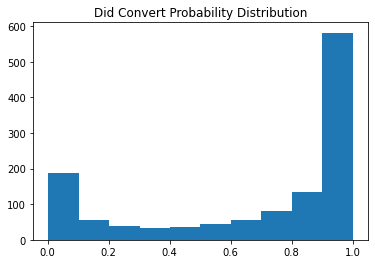

In [140]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

augmented_df = test_df.copy()
augmented_y = augmented_df["converted"]
cols = augmented_df.columns.tolist()
cols.remove("converted")
cols.remove("salary")
augmented_X = augmented_df[cols]

X_train, X_test_augmented, y_train, y_test = train_test_split(
    augmented_X, augmented_y
)
test_clf = LogisticRegression(
    max_iter=1000, class_weight="balanced", 
    C=100, penalty="l2", solver="liblinear"
)
test_clf.fit(X_train, y_train)
y_pred = test_clf.predict(X_test_augmented)
print(classification_report(y_test, y_pred))
print("ROC AUC", roc_auc_score(y_test, y_pred))
plt.hist(test_clf.predict_proba(X_test_augmented).T[1])
plt.title('Did Convert Probability Distribution')
plt.show()

In [114]:
class_one = test_clf.predict_proba(X_test_augmented).T[1]
print(len(class_one[class_one > 0.7]))
print(len(class_one[class_one > 0.7])/len(class_one))

print(len(class_one[class_one < 0.3]))
print(len(class_one[class_one < 0.3])/len(class_one))

735
0.588
262
0.2096


              precision    recall  f1-score   support

           0       0.94      0.71      0.81       982
           1       0.44      0.84      0.58       268

    accuracy                           0.74      1250
   macro avg       0.69      0.78      0.69      1250
weighted avg       0.84      0.74      0.76      1250

ROC AUC 0.7760206097820469


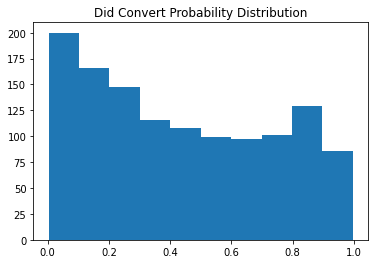

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

control_y = control_df["converted"]
cols = control_df.columns.tolist()
cols.remove("converted")
cols.remove("salary")
control_X = control_df[cols]

X_train, X_test_control, y_train, y_test = train_test_split(
    control_X, control_y
)
control_clf = LogisticRegression(
    max_iter=1000, class_weight="balanced", 
    C=100, penalty="l2", solver="liblinear"
)
control_clf.fit(X_train, y_train)
y_pred = control_clf.predict(X_test_control)
print(classification_report(y_test, y_pred))
print("ROC AUC", roc_auc_score(y_test, y_pred))
plt.hist(control_clf.predict_proba(X_test_control).T[1])
plt.title('Did Convert Probability Distribution')
plt.show()

In [116]:
class_one = control_clf.predict_proba(X_test_control).T[1]
print(len(class_one[class_one > 0.7]))
print(len(class_one[class_one > 0.7])/len(class_one))

print(len(class_one[class_one < 0.3]))
print(len(class_one[class_one < 0.3])/len(class_one))

318
0.2544
497
0.3976


## Interpretation

So we record all of the standard metrics to make sure our model explains what we are seeing well.  Then we look at the probability distributions for convert (y=1) and not convert (y=0).  If

$$ P(converted | test) \nsim P(converted | control)$$ 

then we can say our trial produced a meaningful result and we can say that our test data indeed changed something.

Note: this is a worked example!  If this was the real world and you saw those accuracy measures, you ought to be very, very skeptical.  Especially the second set.

Let's look at the specifics of our example:

For test:

* 735 converted with a high probability and only 262 converted with a low probability.

For control:

* only 318 people converted with a high probability and 497 converted with a low probability.

Also, the spread of the decision functions is somewhat different.  This is can be explained by the difference in precision, recall and F1 score.  The model for control is far less confident about it's predictions than it is for test.  Let's recall the difference in average disposable income between test and control:

In [117]:
print(test_df["disposable_income"].mean())
print(control_df["disposable_income"].mean())
test_df["disposable_income"].mean() - control_df["disposable_income"].mean()

114850.13408600002
19344.240402


95505.89368400002

Around 95K!  That's a huge difference in standard of living.  Let's go back to our model and look at our coefficients:

In [119]:
for index, coef in enumerate(test_clf.coef_[0]):
    if test_df.columns[index] == "salary":
        print("disposable_income", coef)
    else:
        print(test_df.columns[index], coef)

female 0.2946846118333844
male -0.6549736068562345
asian 0.8730138463568186
black 0.27632450992553664
hispanic 0.936456354519452
white -2.446083705824654
high -0.3051595488035577
low -0.0006419496824594507
medium -0.054487496536828564
age -0.005946087760671756
disposable_income 1.6091160193835538e-05


Making use of the calculation for effect size, as we did before.  We see that the effect size for salary is:

$$ \theta * mean(salary) = 1.8480719058613175 $$

that is, 

`1.6091160193835538e-05 * 114850.13 = 1.8480719058613175`

Given that effect size is exponentiated by the base, in this case $e$, the natural number.  We have, an increase in salary by 1 dollar leading to an increase in P(Y=1) of:

$$ e^{1.8480719058613175} = 6.347569005727271 $$

Now let's look at how much of an effect salary has on our control model:

In [120]:
for index, coef in enumerate(control_clf.coef_[0]):
    if test_df.columns[index] == "salary":
        print("disposable_income", coef)
    else:
        print(test_df.columns[index], coef)

female -6.3426394918945975e-06
male -0.000850855103282869
asian 0.00011363699508624182
black -0.00045744173539578105
hispanic 0.00022389906317156683
white -0.0007372920656367937
high -0.00039847470031215116
low -0.00017578497928210558
medium -0.00028293806318050867
age -0.027454865997094135
disposable_income 4.965844768559796e-05


$$ \theta * mean(salary) = 0.9606049500203474 $$

that is, 

`4.965844768559796e-05 * 19344.240402 = 0.9606049500203474`

Given that effect size is exponentiated by the base, in this case $e$, the natural number.  We have, an increase in salary by 1 dollar leading to an increase in P(Y=1) of:

$$ e^{0.9606049500203474} = 2.6132768972483706 $$

This implies disposable income has about three times as much effect in the test model than the control model.  Which feels like it might matter!

Last but not least we will look at the KL-divergence between the two models probabilities to help us figure out how significant the difference in prediction is:

In [145]:
from scipy import stats

print(stats.entropy(
    test_clf.predict_proba(X_test_augmented).T[1], 
    qk=control_clf.predict_proba(X_test_control).T[1]
))
stats.entropy(
    test_clf.predict_proba(X_test_augmented).T[0], 
    qk=control_clf.predict_proba(X_test_control).T[0]
)

0.5595076378390338


0.8212894958878589

While not a metric, the KL divergence can give us a sense for how different these two models probability distributions are.  If the KL divergence is zero, then the two probability distributions are the same.  According to this they are somewhat close!  Overall, what this tells us is that if we find a way to sample test and control, accounting for salary (and therefore disposable income) then we will have an apples to apples comparison.  

We were able to figure out that something was different between our two samples because the probability distributions were different.  By looking at the coeficients and average values, we were able to discern that salary is making our two samples distinct.  This is what shows _how_ we were off.  We were able to conclude things aren't that different by looking at the KL divergence.  We could also look at the descriptive statistics on the individual variables, however comparing all of these might be challenging.  Measures of "closeness" might be hard to obtain between the variables directly.  Therefore KL divergence can act as an okay proxy.  

Just to confirm that the above thinking is correct - let's run the experiment again!  We'll make sure the salaries are sampled from similar distributions this time.

In [147]:
size = 5000
test_salary_mean = 55000
test_salary_variance = 2000 
control_salary_mean = 55000
control_salary_variance = 2000

test_df = generate_data(size, test_salary_mean, test_salary_variance)
control_df = generate_data(size, control_salary_mean, test_salary_variance)
original_df = generate_data(size*2, control_salary_mean, test_salary_variance)
print(test_df["converted"].value_counts()/len(test_df))
print(control_df["converted"].value_counts()/len(control_df))
print(original_df["converted"].value_counts()/len(original_df))

0    0.8374
1    0.1626
Name: converted, dtype: float64
0    0.8412
1    0.1588
Name: converted, dtype: float64
0    0.8429
1    0.1571
Name: converted, dtype: float64


Now that we've sampled again, let's go ahead and recalculate what we need:

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1040
           1       0.67      0.99      0.80       210

    accuracy                           0.92      1250
   macro avg       0.83      0.94      0.87      1250
weighted avg       0.94      0.92      0.92      1250

ROC AUC 0.9433379120879121


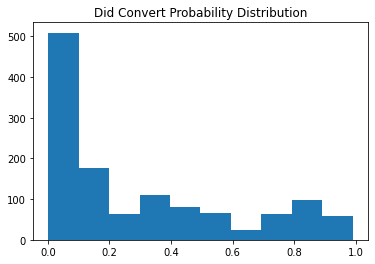

In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

augmented_df = test_df.copy()
augmented_y = augmented_df["converted"]
cols = augmented_df.columns.tolist()
cols.remove("converted")
cols.remove("salary")
augmented_X = augmented_df[cols]

X_train, X_test_augmented, y_train, y_test = train_test_split(
    augmented_X, augmented_y
)
test_clf = LogisticRegression(
    max_iter=1000, class_weight="balanced", 
    C=100, penalty="l2", solver="liblinear"
)
test_clf.fit(X_train, y_train)
y_pred = test_clf.predict(X_test_augmented)
print(classification_report(y_test, y_pred))
print("ROC AUC", roc_auc_score(y_test, y_pred))
plt.hist(test_clf.predict_proba(X_test_augmented).T[1])
plt.title('Did Convert Probability Distribution')
plt.show()

In [128]:
class_one = test_clf.predict_proba(X_test_augmented).T[1]
print(len(class_one[class_one > 0.7]))
print(len(class_one[class_one > 0.7])/len(class_one))

print(len(class_one[class_one < 0.3]))
print(len(class_one[class_one < 0.3])/len(class_one))

196
0.1568
772
0.6176


              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1040
           1       0.85      1.00      0.92       210

    accuracy                           0.97      1250
   macro avg       0.93      0.98      0.95      1250
weighted avg       0.97      0.97      0.97      1250

ROC AUC 0.9822115384615385


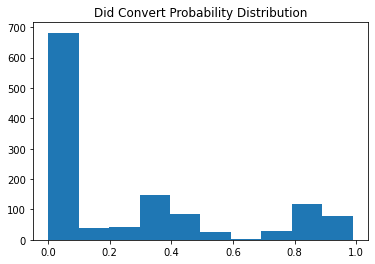

In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

control_y = control_df["converted"]
cols = control_df.columns.tolist()
cols.remove("converted")
cols.remove("salary")
control_X = control_df[cols]

X_train, X_test_control, y_train, y_test = train_test_split(
    control_X, control_y
)
control_clf = LogisticRegression(
    max_iter=1000, class_weight="balanced", 
    C=100, penalty="l2", solver="liblinear"
)
control_clf.fit(X_train, y_train)
y_pred = control_clf.predict(X_test_control)
print(classification_report(y_test, y_pred))
print("ROC AUC", roc_auc_score(y_test, y_pred))
plt.hist(control_clf.predict_proba(X_test_control).T[1])
plt.title('Did Convert Probability Distribution')
plt.show()

In [129]:
class_one = control_clf.predict_proba(X_test_control).T[1]
print(len(class_one[class_one > 0.7]))
print(len(class_one[class_one > 0.7])/len(class_one))

print(len(class_one[class_one < 0.3]))
print(len(class_one[class_one < 0.3])/len(class_one))

218
0.1744
729
0.5832


So far everything looks pretty similar!  Let's go ahead and look at the coeficients on our models:

In [130]:
for index, coef in enumerate(test_clf.coef_[0]):
    if test_df.columns[index] == "salary":
        print("disposable_income", coef)
    else:
        print(test_df.columns[index], coef)

female 0.39969047133645125
male -1.4504322821135125
asian -0.2596477353155232
black -1.2888227354207535
hispanic 1.8837280502167568
white -1.385999390257541
high -0.8515803278356436
low 0.16948398065245837
medium -0.3686454635938748
age -0.017115176234678845
disposable_income 7.22119500728732e-05


In [131]:
for index, coef in enumerate(control_clf.coef_[0]):
    if test_df.columns[index] == "salary":
        print("disposable_income", coef)
    else:
        print(test_df.columns[index], coef)

female 0.41153164334448583
male -1.3396666638763157
asian -0.2384917480148528
black -1.078216580983576
hispanic 1.4138815188081577
white -1.0253082103415576
high -0.692847296741106
low 0.2081631408675101
medium -0.443450864658234
age -0.014480776960789773
disposable_income 6.888622733234604e-05


As you can see, all our coeficients are pretty similar!  Since our data is similar, we don't need to carry out the full calculation to infer effect size.  Finally, let's look at our KL divergence:

In [150]:
from scipy import stats

print(stats.entropy(
    test_clf.predict_proba(X_test_augmented).T[1], 
    qk=control_clf.predict_proba(X_test_control).T[1]
))
stats.entropy(
    test_clf.predict_proba(X_test_augmented).T[0], 
    qk=control_clf.predict_proba(X_test_control).T[0]
)

1.8911807020032905


0.38326048518028133

As you can see, the KL divergence is still small!  So this model is now pretty good.  And we can say definitively, in this case, the change in email for the sale had no effect!  Recall that KL divergence is not a true metric, so just because the KL divergence is bigger here than before says nothing about how much closer these two probability distributions are than the other two we looked at for the previous experiment.  KL divergence only tells us how close these two probability distributions are in "relative" terms.  So a good rule of thumb is anything that produces small numbers is probably close.

## Example Two - Customer Churn

The next typical data science problem we are going to tackle is customer churn!  This is huge for product development, sales cycles and just keeping a business afloat.  If you know and can predict how much your customers are going to churn you can reliably forecast how much revenue to expect per quarter.  Which is basically essential to any and all businesses.  

Since customer churn is so important, it's worth noting that there is more to churn than just what's in your model.  It can help drive decisions, but it's very important to include domain experts in churn conversations.  This means designers, UX and design folks, sales folks, executives and other stakeholders.  All of these folks matter.  For one, your model may not take into account critical variables.  For another thing, you may not be measuring enough.  A good model doesn't replace people, it helps inform a conversation and aids in decision making.

Let's start with some context for what Customer Churn is and go through some possible definitions:

Customer churn, loosely, is the number of customers that will stop paying for your service over a specified period of time.

Definition one:

$$ \frac{customers \space lost \space during \space fixed \space period}{total \space customers \space at \space the \space start \space of \space the \space fixed \space period} $$

Notice, this does not take into account the total number of customers gained.  Say for instance you started out with 100 customers, then you gained 1 million over the course of the fixed period, say a month, and then 15 thousand churned.  Your churn for the month would be:

$$ \frac{15000}{100} = 150 \% $$

If 150% of your customers churn, you might think your business is _not_ doing great.  But you gained like a million new customers over the period!  So in actuality, this is very good news, _overall_.  If you don't get a ton of new customers, this might be a good enough metric.

Definition two:

$$ \frac{Churn}{Customers_{1} + Customers_{n} / 2} $$

Where:

$ Customer_{1} $ := number of customers at the start of the month

$ Customer_{n} $ := number of customers at the end of the month

So over the same window we get:

$$ \frac{15000}{(100 + 1000000)/2} = 0.029\% $$

Which sounds much more reasonable, and accurate.

Definition three:

$$ \frac{Churn}{\frac{1}{n} \displaystyle \sum_{i=1}^{n} Customer_{i}} $$

Here we take the average of the customer count over the period of interest, this further normalizes the churn.

## Modeling Churn

Once you have a good measure of Churn, that works for you, the next step is to understand your Churn number.  For this we'll create a model of the world that incorpates other data to understand when and more importantly why customers churn.

For this example we will be making use of this dataset from kaggle:

https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers

To get this part of the notebook to run, you'll need to download and unzip the data locally (a pain I know).



In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("Churn_Modelling.csv")
df.drop("RowNumber", inplace=True, axis=1)
df.drop("CustomerId", inplace=True, axis=1)
df["Churn"] = df["Exited"] 
df.drop("Exited", inplace=True, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Churn              10000 non-null int64
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


We drop the `RowNumber` and the `CustomerId` since they won't be useful for understanding why our customers churn or stay.  Some of the other information may be useful.  First let's look at `Gender`:

In [3]:
summary = df.pivot_table(values="Churn", index='Gender', aggfunc=np.mean)
summary["Churn %"] = summary["Churn"] 
summary["Churn Total"] = df.pivot_table(values="Churn", index="Gender", aggfunc=np.sum)
summary.drop("Churn", axis=1, inplace=True)
summary

,Churn %,Churn Total
Gender,,
Female,0.250715,1139
Male,0.164559,898


It seems pretty clear that `Gender` is going to matter, and that `Churn` is going to be higher for women than men.

Now let's see if this is True for all countries under consideration:

In [4]:
print(df["Geography"].unique())
summary = df.pivot_table(values="Churn", index=['Gender'], columns=["Geography"], aggfunc=np.mean)
summary

['France' 'Spain' 'Germany']


Geography,France,Germany,Spain
Gender,,,
Female,0.203450,0.375524,0.212121
Male,0.127134,0.278116,0.131124


It appears churn rates are higher across the board for women over men, however churn rates do vary from country to country:

In [5]:
print(df["Geography"].unique())
summary = df.pivot_table(values="Churn", index=['Gender'], columns=["Geography"], aggfunc=np.sum)
summary

['France' 'Spain' 'Germany']


Geography,France,Germany,Spain
Gender,,,
Female,460,448,231
Male,350,366,182


This is probably a function of population size.  However this means explicitly controlling for `Geography` is probably important, because otherwise we may lose a confounding effect, which would lower the generalizability of our analysis.

Next let's look at the effect of age on Churn.  For this we should first run the test for independence followed by a test for correlation.  Recall, we will use Kruskal-Wallis for independence and point bi serial correlation for correlation:

In [6]:
from scipy import stats

print(stats.kruskal(df["Age"], df["Churn"]))
print(stats.pointbiserialr(df["Age"], df["Churn"]))

KruskalResult(statistic=16030.329492796818, pvalue=0.0)
PointbiserialrResult(correlation=0.28532303783506824, pvalue=1.2399313093495365e-186)


With a pvalue of zero we reject the null hypothesis that the two variables are independent.  Additionally, we see a pvalue of close to zero for point bi serial correlation, therefore we reject the null hypothesis of no correlation.  So `Age` is a variable of interest.  We can also confirm this with mutual information:

In [7]:
from sklearn import feature_selection
feature_selection.mutual_info_regression(df["Age"].values.reshape(-1, 1), df["Churn"])

array([0.05610117])

If you haven't read An Introduction to Information Theory yet, the important things to note are when mutual information is 1, the variables are perfectly dependent.  When it's zero they are the same.  So there is some weak information sharing between `Age` and `Churn`.

We can actually go through the rest of the variables to see which ones are likely useful for predicting churn with mutual information:

In [21]:
features = [column for column in df.columns if df[column].dtype != "object"]
features.remove("Churn")
X = df[features]
y = df["Churn"]
ranks = feature_selection.mutual_info_regression(X, y)
rankings = []
for index, feature in enumerate(features):
    rankings.append((feature, ranks[index]))
sorted(rankings, key=lambda t: t[1], reverse=True)

[('Age', 0.09048326288892028),
 ('NumOfProducts', 0.07303749592710229),
 ('IsActiveMember', 0.013130240845428354),
 ('Tenure', 0.00409941408302128),
 ('EstimatedSalary', 0.0027089277988778804),
 ('Balance', 0.00161677556992057),
 ('CreditScore', 0.0006704402476174209),
 ('HasCrCard', 0.0)]

So we see that `NumOfProducts` is the most important and `HasCrCard` is the least important.  Or rather carries the least information about probability of churning.  This is possibly because most people have a credit card these days.

Next let's kick out any variables that don't likely matter.  In this case, we can probably safely remove `HasCrCard`:

In [2]:
df.drop("HasCrCard", axis=1, inplace=True)

Let's also drop `Surname`, since any information it gives us is probably spurious:

In [3]:
df.drop("Surname", axis=1, inplace=True)

Last but not least, let's look at how balanced our classes are.  This will inform what type of classifier we use and what kind of accuracy we can expect:

In [10]:
df["Churn"].value_counts()

0    7963
1    2037
Name: Churn, dtype: int64

As you can see there is some imbalance with about 80% of people not churning from the service.  So we'll need to explicitly account for this.

Now we are almost ready to fit our model!  Let's first get our categorical variables ready:

In [4]:
for column in df.columns:
    if df[column].dtype == "object":
        df = pd.concat([df, pd.get_dummies(df[column])], axis=1)
        df = df.drop(column, axis=1)


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, log_loss

y = df["Churn"]
cols = df.columns.tolist()
cols.remove("Churn")
X = df[cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
logit = LogisticRegression(
    C=1, penalty="l2", max_iter=1000, 
    class_weight="balanced"
)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(log_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.65      0.74      1944
           1       0.35      0.66      0.46       556

    accuracy                           0.65      2500
   macro avg       0.61      0.66      0.60      2500
weighted avg       0.76      0.65      0.68      2500

0.6562953341030878
11.978264824417066


One strategy to deal with class imbalance is by making that explicit.  Here we the `class_weight` hyperparameter to try and adjust for this class imbalance.  What this does is weight examples from the minority class higher than those from the majority class.  Unfortunately our model doesn't do great, so let's see if there are any obvious variables we can remove:

In [31]:
for index, col in enumerate(cols):
    print(col, logit.coef_[0][index])

CreditScore -0.0031436478957918785
Age 0.05898746159233117
Tenure -0.08679665322930301
Balance 3.905155260992167e-06
NumOfProducts -0.039819154004494525
IsActiveMember -0.07847513122067634
EstimatedSalary -9.223377167585139e-07
France -0.04440259570810289
Germany 0.05012964004326264
Spain -0.022347366299728076
Female 0.04293418313482472
Male -0.059554505098413556


None of the variables really jump out as the issue.  You might think that `EstimatedSalary` and `Balance` are the issue, but both of them have much larger values than the rest of the variables.  Let's just confirm that:

In [27]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,199992.480000,1.000000


As you can see, the averages for `EstimatedSalary` and `Balance` are much much higher than the other variables.  So even though they have smaller coefficients, their effect size will be large enough to contribute to the decision boundary.  Next, let's see if the solver or penalty is the issue:

In [32]:
logit_linear = LogisticRegression(
    solver="liblinear",
    C=1, penalty="l1", max_iter=10000, 
    class_weight="balanced"
)
logit_linear.fit(X_train, y_train)
y_pred = logit_linear.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(log_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1944
           1       0.42      0.70      0.53       556

    accuracy                           0.72      2500
   macro avg       0.66      0.71      0.66      2500
weighted avg       0.79      0.72      0.74      2500

0.7127298161470823
9.740107656409736


In [140]:
for index, col in enumerate(cols):
    print(col, logit_linear.coef_[0][index])

CreditScore -0.0006180222871635596
Age 0.0782462365221455
Tenure -0.006832107433490348
Balance 2.6100726865106033e-06
NumOfProducts -0.125957377561036
IsActiveMember -0.8492739668684903
EstimatedSalary 1.2544822574956195e-07
France -0.807417662931865
Germany 0.0
Spain -0.8244401538543713
Female -0.34300710576221705
Male -0.9037524239656831


We do a little bit better with this model, but still not well enough.  Time to bring in another library specifically created to deal with imbalanced classes.

## Dealing with imbalanced data explicitly

There are a few strategies for dealing with imbalanced data.  We've already looked at class weight balancing, which can work in some cases.  But unfortunately doesn't work for our example problem.  Next let's look at under and over sampling.  Before we go through that, let's define what sampling is and why it can be effective.

### Sampling

In a perfect world, we would never need to sample.  We would always have enough data and that data would be our population of interest.  We would know everything about it that was relevant and we would be able to accurately come up with policy interventions or understand some phenomenon.  Unfortunately, in the real world, we have no such luck.  We rarely, if ever, have all the data about our population of interest.  Does that mean that our models are not faithful to the real world, if they are trained on limited data?  The answer is not necessarily!

In chapter one we introduced the notion of the distribution and descriptive statistics.  Loosely defined, a sample is a distribution of data that comes from a large population distribution.  One way to measure similarity between the sample and the population distribution is to see if their descriptive statistics, also known as their characteristics, are similar.

Let's look at an example!

Suppose there exists the following population distribution:

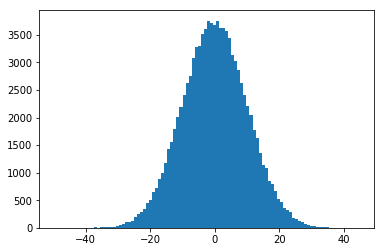

Mean: -0.038410954520667805
Standard Devation: 9.991669662907558


In [41]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

population = np.random.normal(0, 10, size=100000)

bins = 100
plt.hist(population, bins=bins)
plt.show()
print("Mean:", np.mean(population))
print("Standard Devation:", np.std(population))

Now assume we can only take samples of this population and that the financial cost of extracting the next sample increases overtime.  So let's say that the cost increases linearly with each sample extracted, by a rate of 2 cents more per sample.  Let's see how cost increases as we draw more samples:

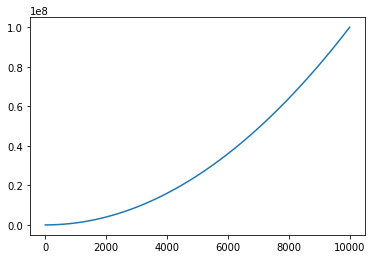

In [43]:
sample_size = np.linspace(0, 10000)
cost_for_sample_i = sample_size ** 2

plt.plot(sample_size, cost_for_sample_i)
plt.show()

This means that the 10,000th sample costs 10,000,000 dollars in total!!!  That's a huge cost!  And that's at a rate of increase of 2 cents more per sample!  So these things can get very, very pricey.  The cost associated with obtaining a large sample or obtaining the entire population can be prohibitive.  If you think this example is an overstatement of reality, the 2010 census cost 13 billion dollars.  That's approximately 100 times more expensive than our worked example.  

Hopefully I've motivated sampling for you and it's importance.  Now let's go through some techniques:  

The first is just a random sample of the population distribution:

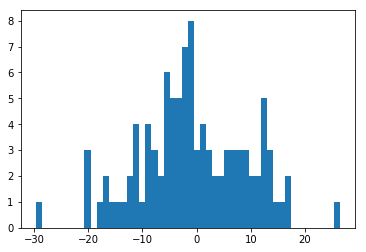

Mean: -0.7528969913432664
Standard Devation: 9.8871479957865


In [49]:
import random

sample_size = 100
sample = np.random.choice(population, size=sample_size, replace=False)
bins = 50
plt.hist(sample, bins=bins)
plt.show()
print("Mean:", np.mean(sample))
print("Standard Devation:", np.std(sample))

There are a few things to call out here:

1) The sample is much less bell shaped than our population.  This is to be expected, since there is a lot less data and therefore the shape of our distribution is a lot less smooth.

2) The population mean and the sample mean are close.  This is exactly what we'd hope for from a representative sample, our descriptive statistics aren't that far off from one another.  Recall, statistics like the mean are sensitive to outliers, which in some cases are a negative, but here that sensitivity actually helps ensure that we are as close as possible.  Of course, you should still look out for outliers, because if your sample is made up mostly of outliers, it may be the case that your sample "appears" good from your descriptive statistics, when in reality, your data is not representative.  That is why it's a good idea to capture multiple measures of center and spread and ensure they all align.

3) The population standard deviation and sample standard deviation are close.  The fact that the spread about the center is similar is a good sign.  Unfortunately, the standard deviation is also not great at dealing with outliers, so it's best to include other statistics as well to compensate for this.

4) We chose to sample without replacement, via `replace=False`.  This means once we've drawn a sample from our population we cannot draw that sample again.  Sampling with and without replacement is a huge decision in modeling.  If you sample with replacement then it's possible your model could just memorize the data and have terrible generalization.  So it's important, if you do sample with replacement that you truly need to.

Now that we have seen _a_ sampling technique in action, let's apply it to our problem.  We are going to do the following things:

1) write a function that samples from our training data (not our testing data)
2) this function must create samples that satisify the descriptive statistics of our original dataset (as close as we can get them)
3) we will specifically be upsampling, aka sampling with replacement from the minority class.  And taking a random sample from our majority class.  By down sampling, aka sampling without replacement, from our majority class we need to upsample less from our minority class.  
4) We'll try different levels of upsampling and downsampling such that our test set accuracy is maximized.  
5) finally we'll look at results on a validation set of previously unseen examples to make sure everything wasn't overtuned for the test set.

In [1]:
from scipy.stats import iqr
import numpy as np
from sklearn.ensemble import IsolationForest

def trimean(arr):
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)
    median = np.percentile(arr, 50)
    return (q1 + 2*median + q3)/4

def compare_categorical_indices(population_value_proportions, sample_index, population_index, missing_tolerance, include_outliers):
    if include_outliers:
        if (sample_index != population_index).all():
            object_outside_tolerance = True
        else:
            object_outside_tolerance = False
    else:
        majority_population_indices = []
        for index in population_index:
            if population_value_proportions[index] > missing_tolerance:
                majority_population_indices.append(index)
        sample_index_list = list(sample_index)
        sample_index_list.sort()
        majority_population_indices.sort()
        if sample_index_list == majority_population_indices:
            object_outside_tolerance = True
        else:
            object_outside_tolerance = False
    return object_outside_tolerance

def compare_categorical_statistic(tolerance, population_value_proportions, sample_value_proportions, sample_index):
    population_proportions_in_sample = population_value_proportions[sample_index]
    proportional_differences = population_proportions_in_sample - sample_value_proportions
    delta = 0
    outside_tolerance = False
    for proportion_difference in proportional_differences:
        if proportion_difference > tolerance:
            outside_tolerance = True
        delta += abs(proportion_difference)
    return outside_tolerance, delta

def compare_categorical(df, sample, column, tolerance, missing_tolerance, include_outliers):
    population_value_proportions = df[column].value_counts()/len(df)
    sample_value_proportions = sample[column].value_counts()/len(sample)
    
    sample_index = sample_value_proportions.index.sort_values()
    population_index = population_value_proportions.index.sort_values()
    
    outside_tolerance_indices = compare_categorical_indices(
        population_value_proportions, sample_index, population_index, 
        missing_tolerance, include_outliers
    )
    outside_tolerance_statistic, delta = compare_categorical_statistic(
        tolerance, population_value_proportions, sample_value_proportions, sample_index
    )
    outside_tolerance = outside_tolerance_indices and outside_tolerance_statistic
    return outside_tolerance, delta
    
def prune_outliers(df, sample, column):
    forest = IsolationForest(n_estimators=10, warm_start=False)
    forest.fit(df[column].values.reshape(-1, 1))
    is_inlier_population = forest.predict(df[column].values.reshape(-1, 1))
    is_inlier_population = pd.Series(is_inlier_population)
    is_inlier_population.index = df.index
    is_inlier_population = is_inlier_population.map({1: True, -1: False})
    population_column = df[column][is_inlier_population]
    is_inlier_sample = forest.predict(sample[column].values.reshape(-1, 1))
    is_inlier_sample = pd.Series(is_inlier_sample)
    is_inlier_sample.index = sample.index
    is_inlier_sample = is_inlier_sample.map({1: True, -1: False})
    sample_column = sample[column][is_inlier_sample]
    return population_column, sample_column 
    
def compare_continuous(df, sample, column, tolerance, include_outliers):
    mean_outside_tolerance = False
    trimean_outside_tolerance = False
    stdev_outside_tolerance = False
    iqr_outside_tolerance = False
    
    if not include_outliers:
        population_column, sample_column = prune_outliers(df, sample, column)
    else:
        population_column, sample_column = df[column], sample[column]
        
    mean_deviation = abs(population_column.mean() - sample_column.mean())
    trimean_deviation = abs(trimean(population_column) - trimean(sample_column))
    stdev_deviation = abs(population_column.std() - sample_column.std())
    iqr_deviation = abs(iqr(population_column) - iqr(sample_column))
    
    if mean_deviation > tolerance:
        mean_outside_tolerance = True
    if trimean_deviation > tolerance:
        trimean_outside_tolerance = True
    if stdev_deviation > tolerance:
        stdev_outside_tolerance = True
    if iqr_deviation > tolerance:
        iqr_outside_tolerance = True
    delta = mean_deviation + trimean_deviation + stdev_deviation + iqr_deviation
    outside_tolerance = mean_outside_tolerance and trimean_outside_tolerance 
    outside_tolerance = outside_tolerance and stdev_outside_tolerance
    outside_tolerance = outside_tolerance and iqr_outside_tolerance
    return outside_tolerance, delta
    
def compare_columns(df, sample, column, column_type,
                    tolerance, outside_tolerance, 
                    missing_tolerance, include_outliers):
    if column_type == "categorical":
        categorical_outside_tolerance, delta = compare_categorical(
            df, sample, column, tolerance, 
            missing_tolerance, include_outliers
        )
        outside_tolerance = outside_tolerance and categorical_outside_tolerance
    if column_type == "continuous":
        continuous_outside_tolerance, delta = compare_continuous(
            df, sample, column, tolerance, include_outliers
        )
        outside_tolerance = outside_tolerance and continuous_outside_tolerance
    return outside_tolerance, delta
        
def bootstrap(df, column_types, size=1000, tolerance=0.1, 
              max_iter=1000, missing_tolerance=0.1, 
              with_replacement=False, include_outliers=False):
    outside_tolerance = True
    best_sample = None
    cur_iter = 0
    if max_iter != -1:
        limited_iter = True
    else:
        limited_iter = False
    while outside_tolerance:
        sample = df.sample(n=size, replace=with_replacement)
        overall_delta = 0
        min_overall_delta = 1e10
        for column in df.columns:
            column_type = column_types[column]
            outside_tolerance, marginal_delta = compare_columns(
                df, sample, column, column_type, 
                tolerance, outside_tolerance,
                missing_tolerance, include_outliers
            )
            overall_delta += marginal_delta
        if not outside_tolerance:
            best_sample = sample
        elif overall_delta < min_overall_delta:
            min_overall_delta = overall_delta
            best_sample = sample
        cur_iter += 1
        if limited_iter and cur_iter == max_iter:
            break
    return best_sample

column_types = {
    "CreditScore": "continuous",
    "Age": "continuous",
    "Tenure": "continuous",
    "Balance": "continuous",
    "NumOfProducts": "categorical",
    "IsActiveMember": "categorical",
    "EstimatedSalary": "continuous",
    "Churn": "categorical",
    "France": "categorical",
    "Germany": "categorical",
    "Spain": "categorical",
    "Female": "categorical",
    "Male": "categorical"
}
sample = bootstrap(df, column_types)

We run our bootstrap to create a sample, just to confirm the representativeness of our sample:

In [6]:
sample.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Churn,France,Germany,Spain,Female,Male
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,652.532000,39.304000,5.013000,78722.653150,1.595000,0.544000,98596.245520,0.185000,0.486000,0.268000,0.246000,0.466000,0.534000
std,96.292893,10.796673,2.908486,63429.830282,0.572103,0.498309,56992.503264,0.388492,0.500054,0.443139,0.430894,0.499092,0.499092
min,351.000000,18.000000,0.000000,0.000000,1.000000,0.000000,91.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,583.500000,32.000000,2.000000,0.000000,1.000000,0.000000,50317.887500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,656.000000,38.000000,5.000000,98629.800000,2.000000,1.000000,96618.600000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,721.000000,45.000000,8.000000,129767.917500,2.000000,1.000000,145189.810000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,850.000000,79.000000,10.000000,209490.210000,4.000000,1.000000,199505.530000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Churn,France,Germany,Spain,Female,Male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.515100,100090.239881,0.203700,0.501400,0.250900,0.247700,0.454300,0.545700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.499797,57510.492818,0.402769,0.500023,0.433553,0.431698,0.497932,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.000000,100193.915000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.000000,149388.247500,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
df.shape, sample.shape

((10000, 13), (1000, 13))

As you can see all of the proportions are pretty close for all the variables!  Also note, that our sample is a 10th the size from our original!!!  We are now in a place to generate our upsample for the minor class and our down sample for the majority class.

We do this with the following steps:

1. split into test, train and validation - 

2. we upsample and down sample on train and tune over test.  

3. Then we validate on validation.  We should only validate once!

## Don't Balance Test or Validation Data EVER

Before we go through the code, I just want to make this point very explicit.  It is _incredibly_ important that we only mess around with our training data and not our testing or validation data.  This is because our testing and validation data should resemble the real world.  The world in which the data is unbalanced.  We cannot and should not assume that eventually there will be a world in which our classes are balanced.  So if we make our testing or validation data set balanced, any metrics we report will be wrong, because they are based on a false assumption.

In [9]:
train["Churn"].value_counts()

0    4005
1     995
Name: Churn, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score, log_loss, 
    precision_score, recall_score, f1_score
)

def resample_data(training_data, minority_size, majority_size):
    minority = training_data[training_data["Churn"] == 1]
    majority = training_data[training_data["Churn"] == 0]
    
    column_types = {
        "CreditScore": "continuous",
        "Age": "continuous",
        "Tenure": "continuous",
        "Balance": "continuous",
        "NumOfProducts": "categorical",
        "IsActiveMember": "categorical",
        "EstimatedSalary": "continuous",
        "Churn": "categorical",
        "France": "categorical",
        "Germany": "categorical",
        "Spain": "categorical",
        "Female": "categorical",
        "Male": "categorical"
    }

    minority_sample = bootstrap(minority, column_types, size=minority_size, with_replacement=True)
    majority_sample = bootstrap(majority, column_types, size=majority_size, with_replacement=False)
    new_train = minority_sample.append(majority_sample)
    for _ in range(10):
        new_train = new_train.sample(frac=1.0)
    return new_train

# step one
y = df["Churn"]
cols = df.columns.tolist()
cols.remove("Churn")
X = df[cols]

# split into 50/50 test train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=12, test_size=.5
)

# split test into 50/50 test validation
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, random_state=12, test_size=.5
)

train = X_train.copy()
train["Churn"] = y_train.copy()

minority_sizes = [
    3000, 2000, 1000,
    1000, 1000, 
    3000, 3000,
    3000, 2000, 1000
]
majority_sizes = [
    3000, 2000, 1000,
    3000, 2000,
    1000, 2000,
    4000, 4000, 4000
    
]
sizes = zip(minority_sizes, majority_sizes)
best_overall_score = 0
best_y_pred = None
best_classifier = None
for minority_size, majority_size in sizes:
    overall_score = []
    new_train = resample_data(
        train, minority_size, majority_size
    )

    y_train = new_train["Churn"]
    cols = new_train.columns.tolist()
    cols.remove("Churn")
    X_train = new_train[cols]

    logit_linear = LogisticRegression(
        solver="liblinear",
        C=1, penalty="l1", max_iter=10000, 
    )
    logit_linear.fit(X_train, y_train)
    y_pred = logit_linear.predict(X_test)
    overall_score.append(
        precision_score(y_test, y_pred)
    )
    overall_score.append(
        recall_score(y_test, y_pred)
    )
    overall_score.append(
        roc_auc_score(y_test, y_pred)
    )
    overall_score.append(
        f1_score(y_test, y_pred)
    )
    overall_score = np.mean(overall_score)
    if overall_score > best_overall_score:
        best_overall_score = overall_score
        best_y_pred = y_pred
        best_classifier = logit_linear
    
print(classification_report(y_test, best_y_pred))
print(roc_auc_score(y_test, best_y_pred))
print(log_loss(y_test, best_y_pred))

y_pred_val = best_classifier.predict(X_val)
print(classification_report(y_val, y_pred_val))
print(roc_auc_score(y_val, y_pred_val))
print(log_loss(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      2002
           1       0.39      0.70      0.50       498

    accuracy                           0.72      2500
   macro avg       0.65      0.71      0.65      2500
weighted avg       0.80      0.72      0.74      2500

0.712539468563565
9.684849452245544
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1956
           1       0.42      0.69      0.52       544

    accuracy                           0.72      2500
   macro avg       0.66      0.71      0.66      2500
weighted avg       0.79      0.72      0.74      2500

0.7121526524720317
9.532869240938773


Old score:
```
           precision    recall  f1-score   support

           0       0.89      0.72      0.80      1944
           1       0.42      0.70      0.53       556

    accuracy                           0.72      2500
   macro avg       0.66      0.71      0.66      2500
weighted avg       0.79      0.72      0.74      2500

0.7127298161470823
9.740107656409736
```

As you can see, in this case our naive bootstrap sampling algorithm doesn't do any better.  It makes the data a little bit better for class 0 (no churn), but a little worse for class 1 (churn) on the test set.  Since the changes are so small, this could honestly just be because of a reduction in training size.  The classifier does a little bit better on the validation set, but that might just be how easy it was to classify that section of the data.  We can't draw any real conclusions about increased accuracy.

So is sampling useful for classification?  The answer is possibly!  We didn't do much better with our naive sampler, but now let's make use of two sampling techniques built for this type of problem, rather than a generic sampler:

* Synthetic Minority Oversampling Technique - SMOTE
* Adaptive Synthetic sampling method - ADASYN

I won't go super into the details, but these two samplers are part of `imbalanced-learn` a package developed just to deal with imbalanced data.

Let's see how these two algorithms do with our problem:

In [74]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

y = df["Churn"]
cols = df.columns.tolist()
cols.remove("Churn")
X = df[cols]

smote = SMOTE()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=12, test_size=0.2
)
X_train, y_train = smote.fit_resample(X_train, y_train)
logit_linear = LogisticRegression(
    solver="liblinear",
    C=1, penalty="l1", max_iter=10000, 
)
logit_linear.fit(X_train, y_train)
y_pred = logit_linear.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(log_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1564
           1       0.56      0.39      0.46       436

    accuracy                           0.80      2000
   macro avg       0.70      0.65      0.67      2000
weighted avg       0.78      0.80      0.79      2000

0.6547285248363406
6.856000287618878


In [75]:
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

y = df["Churn"]
cols = df.columns.tolist()
cols.remove("Churn")
X = df[cols]

adasyn = ADASYN()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=12, test_size=0.2
)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

logit_linear = LogisticRegression(
    solver="liblinear",
    C=1, penalty="l1", max_iter=10000, 
    class_weight="balanced"
)
logit_linear.fit(X_train, y_train)
y_pred = logit_linear.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(log_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1564
           1       0.57      0.39      0.46       436

    accuracy                           0.80      2000
   macro avg       0.71      0.65      0.67      2000
weighted avg       0.78      0.80      0.79      2000

0.6535260095262676
6.786919936238052


So we do a bit better on class 0, but worse on class 1.  

**One important thing to note:** _We only resample on training data, never on testing_.  

If we resample on testing data then we shouldn't trust our results, because it doesn't actually match the real world anymore.  Imbalanced learn comes with some other tools and techniques.  Let's see if adding those improves things.  I know I said this already, but I'm repeating it so it sticks.

First let's get a baseline from scikit-learn:

In [76]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

y = df["Churn"]
cols = df.columns.tolist()
cols.remove("Churn")
X = df[cols]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0
)
bc = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(), 
    random_state=0
)
bc.fit(X_train, y_train) 

y_pred = bc.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(log_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1991
           1       0.70      0.50      0.58       509

    accuracy                           0.86      2500
   macro avg       0.79      0.72      0.75      2500
weighted avg       0.84      0.86      0.85      2500

0.7226379217283276
5.00124904475308


This time we did better, so maybe a decision tree was actually the way to go all along.  Let's see if using the imbalanced bagger will make a difference:

In [77]:
from imblearn.ensemble import BalancedBaggingClassifier

bbc = BalancedBaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    sampling_strategy='auto',
    replacement=False,
    random_state=0
)
bbc.fit(X_train, y_train) 

y_pred = bbc.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(log_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1991
           1       0.54      0.68      0.60       509

    accuracy                           0.82      2500
   macro avg       0.73      0.77      0.74      2500
weighted avg       0.84      0.82      0.82      2500

0.7660498767045024
6.313782357647464


We definitely did better!  Looks like using the imbalanced bagging really helped out a lot!  But still lots of room for improvement.  Notice that the log loss went up by some.  Next let's try doing both a sampler and a balanced classifier:

In [78]:
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedBaggingClassifier

y = df["Churn"]
cols = df.columns.tolist()
cols.remove("Churn")
X = df[cols]

adasyn = ADASYN()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=12, test_size=0.2
)

X_train, y_train = adasyn.fit_resample(X_train, y_train)

bbc = BalancedBaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    sampling_strategy='auto',
    replacement=False,
    random_state=0
)
bbc.fit(X_train, y_train) 

y_pred = bbc.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(log_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1564
           1       0.66      0.57      0.61       436

    accuracy                           0.84      2000
   macro avg       0.77      0.74      0.76      2000
weighted avg       0.84      0.84      0.84      2000

0.7438026467068679
5.43990805663525


Here's the score from the logistic regression for comparison:

```
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1564
           1       0.57      0.39      0.46       436

    accuracy                           0.80      2000
   macro avg       0.71      0.65      0.67      2000
weighted avg       0.78      0.80      0.79      2000

0.6535260095262676
6.786919936238052
```

So it looks like the balanced decision tree does the best of what we've seen so far!  While we didn't do "great", sampling plus using a specialized classifier built for imbalanced data definitely _helps_.  Let's just try one more thing before we head onto anamoly detection:

In [79]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split

y = df["Churn"]
cols = df.columns.tolist()
cols.remove("Churn")
X = df[cols]

adasyn = ADASYN()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=12, test_size=0.2
)

X_train, y_train = adasyn.fit_resample(X_train, y_train)

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
brf.fit(X_train, y_train) 
y_pred = brf.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(log_loss(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1564
           1       0.70      0.56      0.62       436

    accuracy                           0.85      2000
   macro avg       0.79      0.75      0.77      2000
weighted avg       0.84      0.85      0.85      2000

0.7465684319200356
5.111780485513152


This classifier definitely does the best!  We are almost to pretty solid classification, the only thing that's really lagging is the recall for class 1.  That means, we are only capturing 56% of the total number of cases of Churn.  At least, of those that we think are Churn, we are right 70% of the time!  Basically, it looks like our classifier is a little over eager in classifying folks as not churning.  But I think that's fine!  Since most folks won't churn.  This seems like the best we are going to do.  There is more stuff in the imbalanced-learn package we could try, like adding more metrics and trying different samplers.  But I leave that as an exercise to the reader.  We also didn't exhaust the list of possible classifiers, including using deep learning!!!  But we'll get to that in a later chapter.  Anywho, onto anamoly detection!


## Anamoly Detection

It's time for to deal with the problem that is the bane of every data scientists existance - anamoly detection.  If you've never dealt with one of these before, don't worry, at some point you will.  These things come up _a lot_ in information extraction from text.  But they also come up generally in a bunch of places.  Normal models won't work, no matter what you try.  And worse then that, you might not even realize you are dealing with an anamoly detection problem until it's far too late.  As in, you've gone to production and the sample data you saw for training and testing was _far_ too curated.  

Anamoly detection, is basically when your data falls into a class around 90-95% and about 10% or less the rest of the time.  It may be the case that this happens because, like I stated above the data you saw when you were developing the model was _not_ representative.  This can get _especially_ bad with multiclass classification where multiple classes are relatively rare in production.  You might say, these cases are easy!  Just ignore the rare classes, no point in dredging the swamp for the extra little bit of value!  And honestly, that might be a good answer, _sometimes_.  But you won't always get lucky with who you are employed by, who your boss is, or what they care about.

Or in some cases, it may be by the design of the problem.  Of course, the first scenario is _far_ worse, so we will focus on the second case, where there is an anamolous class, by design.  We will also focus on the case of binary classification, because multiclass classification, is frankly speaking, just too hard.

### Problem Set up - Credit Card Fraud Detection

The problem of fraud is fairly straight forward - someone uses your card for a purchase that's "weird" and the credit card company tells you about it.  Of course, this case isn't going to happen often (we hope).  So it's the minority class by _a lot_.  We might not have many examples per customer of this occurring.  However, we may have 'enough' examples over the course of many customers.  This of course, means there will be a lot more cases of transactions where this _didn't_ happen, which can be tough, because your classifier will just learn the majority class.  This also may not be reflected in your metrics since precision, recall and f1 score will all look _great_.  However, really what this means is, they are great for the majority class, not the minority class.

### Our data

Our data comes from this kaggle competition: https://www.kaggle.com/mlg-ulb/creditcardfraud

Let's go ahead and do some exploration:

In [2]:
import pandas as pd

df = pd.read_csv("creditcard.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

As you can see there a bunch of features prepended with a "V".  These are probably hidden pieces of information about individuals.  Of course, we don't want to snoop into anyone's personal lives, so we'll just take these features as a given.  Let's look at correlation between each of these features and the "Class" which is our label:

In [67]:
from scipy import stats

independent = []
no_correlation = []
for column in df.columns:
    if column == "Class":
        continue
    label = df["Class"]
    if stats.kruskal(label, df[column]).pvalue > 0.01:
        independent.append(column)
    if stats.pointbiserialr(label, df[column]).pvalue > 0.01:
        no_correlation.append(column)
        
print("Independent columns", independent)
print("Columns with no correlation", no_correlation)

Independent columns ['V19']
Columns with no correlation ['V13', 'V15', 'V22', 'V23', 'V25', 'V26']


Looks like we can kick out some columns at the start.  But just to get a baseline, let's see how the a classifier does with all the columns being used:

In [66]:
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

y = df["Class"].copy()
columns = df.columns.tolist()
columns.remove("Class")
X = df[columns].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)

logit_clf = LogisticRegression(
    C=1, solver="liblinear", penalty="l1", 
    class_weight="balanced", max_iter=10000
)

logit_clf.fit(X_train, y_train)
y_pred = logit_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(log_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71078
           1       0.06      0.90      0.12       124

    accuracy                           0.98     71202
   macro avg       0.53      0.94      0.55     71202
weighted avg       1.00      0.98      0.99     71202

0.9400059362318
0.8062240625839364


It may seem like we did mostly pretty good!  At least we did on class 0.  The real problem is what's happening in class 1, the minority class and unfortunately the one we care about getting right, a lot.

So what does high recall, low precision mean?  

Remember that precision is:

$$ \frac{true \space positive}{true \space positive + false \space positive} $$

This basically tells us of the things that we classified as fraud, how many of them actually were fraud.  So with this classifier, the number of times we actually found fraud was pretty low, but our classifier _thought_ we found it a lot.  Basically 94% of the time when it predicted "this is fraud", it wasn't fraud.  Ouch!  That sounds pretty bad!

Let's look at the other side of the story:

Remember that recall is:

$$ \frac{true \space positive}{true \space positive + false \space negative} $$

So the false negatives are the times when we thought we didn't have fraud but we actually did.  The ratio here can be a little bit more tricky, since we don't actually deal with negative cases.  I think this is what trips people up the most about recall - it just looks at the number of cases that were actually in the class.  So 90% of the cases in the test set that were actually class 1, were found by the classifier.  

This means, that our classifier is over eager in classifying charges as fraud.  So one of the ways you can deal with this is by having a human verify charges.  Just have everyone that's classified as fraud sent to someone for verification.  This is what actually happens in the real world with most systems.  So are we done?  We've basically matched the performance of the systems that are actually in production, right?  Or at least somewhat close.  

The next thing to do is try to improve things.  Let's start by kicking out those features we knew had no correlation or were independent:

In [68]:
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

columns_to_remove = [
    "V19", 'V13', 'V15', 
    'V22', 'V23', 'V25', 
    'V26', "Class"
]
y = df["Class"].copy()
columns = df.columns.tolist()
for column_to_remove in columns_to_remove:
    columns.remove(column_to_remove)
X = df[columns].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)

logit_clf = LogisticRegression(
    C=1, solver="liblinear", penalty="l1", 
    class_weight="balanced", max_iter=10000
)

logit_clf.fit(X_train, y_train)
y_pred = logit_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(log_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71078
           1       0.06      0.89      0.12       124

    accuracy                           0.98     71202
   macro avg       0.53      0.93      0.55     71202
weighted avg       1.00      0.98      0.99     71202

0.9318218331701021
0.8154408029094835


So we don't do any better.  Well, let's try our resampling strategy like last time, that might work!

In [81]:
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedBaggingClassifier

y = df["Class"].copy()
cols = df.columns.tolist()
cols.remove("Class")
X = df[cols].copy()

adasyn = ADASYN()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=12, test_size=0.2
)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

bbc = BalancedBaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    sampling_strategy='auto',
    replacement=False,
    random_state=0
)
bbc.fit(X_train, y_train) 

y_pred = bbc.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(log_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56869
           1       0.56      0.81      0.66        93

    accuracy                           1.00     56962
   macro avg       0.78      0.90      0.83     56962
weighted avg       1.00      1.00      1.00     56962

0.9027158625454426
0.046083237643766366


So this appears to work better!  Not perfect, but we got our precision _way_ up!!  Can we do even better than that?  It's time introduce a new topic that we've lightly touched up, that of outlier detection.  By treating the minority class as outliers, we may be able to more accurately predict the minority class.

The naive approach to outlier detection is look at magnitude.  Consider the following example:

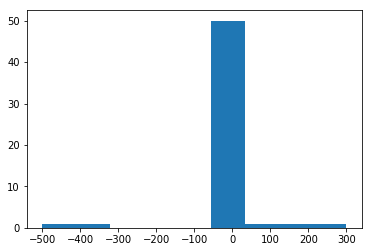

In [20]:
import numpy as np
import matplotlib.pyplot as plt

distribution = np.random.normal(0, 1, size=50)
distribution = np.append(distribution, [100, 200, 300, -400, -500])
plt.hist(distribution, bins=9)
plt.show()

As you can see, the data is mostly centered around one, but there are some outliers.  How might we detect these?  One way is to use the z-score.  Let's define this tool mathematically and then see how to use it:

$$ \frac{x - \mu}{\sigma} $$ 

Where $x$ := the individual element

$ \mu $ := the mean

$ \sigma $ := the standard deviation

So the z-score is the element's distance from the mean, accounting for the distribution of all the points.  Let's see how this works for our example:

In [25]:
from scipy import stats
for index, zscore in enumerate(stats.zscore(distribution)):
    if abs(zscore) > 1.0:
        print(distribution[index])

100.0
200.0
300.0
-400.0
-500.0


Looks like we were able to recover all the outliers!  What do we do when the data is multivariate?  Does the notion of the z-score scale?

Turns out it does!  

## Enter Mahalanobis Distance

The Mahalanobis distance is a generalization of the z-score where instead of considering the distance from a point to the mean, we consider the distance between a point and distribution.  There are three big differences between Mahalanobis distance and z-score:

1) we are dealing with vectors and matrices
2) we use the covariance matrix as our normalization rather than the standard deviation
3) since we have no global mean, we use the mean with respect to each variable in our vector

Let's look at the equation:

$$ D(x) = \sqrt{(x - \mu)^{T}S^{-1}(x- \mu)} $$

Here we define:

$ x $ := an observation, such that:

$$ x := (x_{1}, x_{2}, x_{3}, ... x_{n}) $$

So $x_{i}$ represents the ith element in a given observation.

$ \mu $ := the mean for each of the positional elements of the observation, expressed as a vector such that:

$$ \mu := (\mu_{1}, \mu_{2}, \mu_{3}, ... \mu_{n}) $$

So $ \mu_{i}$ is the mean for the ith position across all the observations.

$S$ := the covariance matrix for the multivariate distribution.

This formalization of distance leads to the following conclusions about how a Mahalanobis distance behaves:

1) It transforms the columns into uncorrelated variables because we normalize by the covariance as well as demean the data.
2) Scale the columns to make their variance equal to 1.

Now let's look at an implementation of Mahalanobis distance as a classifier!

In [80]:
from scipy import linalg
import numpy as np

def mahalanobis(x, distribution, covariance=None):
    x_demeaned = x - np.mean(distribution)
    if covariance is None:
        covariance = np.cov(distribution.values.T)
    inverse_covariance = linalg.inv(covariance)
    left_term = np.dot(x_demeaned, inverse_covariance)
    mahalanobis_distance = np.dot(left_term, x_demeaned.T)
    return mahalanobis_distance.diagonal()

class MahalanobisBinaryClassifier():
    def __init__(self):
        pass

    def fit(self, X_train, y_train):
        class_one_index = y_train[y_train == 1].index
        class_zero_index = y_train[y_train == 0].index
        self.X_train_pos = X_train.loc[class_one_index]
        self.X_train_neg = X_train.loc[class_zero_index]
        self.positive_cov = np.cov(
            self.X_train_pos.values.T
        )
        self.negative_cov = np.cov(
            self.X_train_neg.values.T
        )
        
    def predict_proba(self, X_test):
        negative_distribution = mahalanobis(
            X_test, self.X_train_neg, 
            covariance = self.positive_cov
        )
        positive_distribution = mahalanobis(
            X_test, self.X_train_pos, 
            covariance = self.negative_cov
        )
        positive_negative_distribution = zip(
            positive_distribution, negative_distribution
        )
        probabilities = []
        for positive, negative in positive_negative_distribution:
            denominator = positive + negative
            probability_class_zero = 1 - (negative/denominator)
            probability_class_one = 1 - (positive/denominator)
            probabilities.append(
                [probability_class_zero, probability_class_one]
            ) 
        return np.array(probabilities)
    
    def predict(self, X_test):
        predictions = []
        for row in self.predict_proba(X_test):
            predictions.append(np.argmax(row))
        return np.array(predictions)

sample_size = 30000
column_types = {column: "continuous" for column in df.columns}
sample = bootstrap(df, column_types, size=sample_size, with_replacement=False, include_outliers=True)

y = sample["Class"].copy()
columns = sample.columns.tolist()
columns.remove("Class")
X = sample[columns].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12
)

clf = MahalanobisBinaryClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(log_loss(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5992
           1       0.00      1.00      0.00         8

    accuracy                           0.00      6000
   macro avg       0.00      0.50      0.00      6000
weighted avg       0.00      0.00      0.00      6000

0.5
34.49352322435109


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



For comparison here are the results of the sampling strategy:

```
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56869
           1       0.56      0.81      0.66        93

    accuracy                           1.00     56962
   macro avg       0.78      0.90      0.83     56962
weighted avg       1.00      1.00      1.00     56962
```

And here are the results of our naive classifer:

```
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71078
           1       0.06      0.90      0.12       124

    accuracy                           0.98     71202
   macro avg       0.53      0.94      0.55     71202
weighted avg       1.00      0.98      0.99     71202

0.9400059362318
0.8062240625839364
```

So it may seem like this is a bust, however it does manage to get 100% recall, which is definitely something!  It could be that the mahalanobis distance is simply too naive a strategy.  But given this high recall, there is definitely something to consider for outlier detection.  

Also note, that we have to sample just because we run out of memory if we try to train on the full dataset.

References:
* https://towardsdatascience.com/hands-on-predict-customer-churn-5c2a42806266
* https://blog.markgrowth.com/eliminating-churn-is-growth-hacking-2-0-47a380194a06
* https://towardsdatascience.com/churn-prediction-3a4a36c2129a
https://www.profitwell.com/blog/the-complete-saas-guide-to-calculating-churn-rate-and-keeping-it-simple
* https://www.machinelearningplus.com/statistics/mahalanobis-distance/
* https://towardsdatascience.com/outlier-detection-with-one-class-svms-5403a1a1878c